In [77]:
import torch
from torch.nn import functional as F

repre = torch.load('repr.pt')
label = torch.load('label.pt')
tensor_a = F.pad(repre, (0, 1)) 
tensor_b = F.pad(label, (1, 0))

# 对应向量乘积
scores = []
for i in range(len(tensor_a)):
    scores.append(torch.norm((tensor_a[i] - tensor_b[i]) , dim=-1).cpu().detach())


In [143]:

# 对应向量乘积
scores = []
for i in range(len(tensor_a)):
    scores.append(torch.mean(torch.matmul(repre[i], repre[i].T).cpu().detach() / torch.norm(repre[i]), dim=1))

In [78]:
def calculate_sim(y):
    sim = (torch.bmm(y, y.transpose(-1,-2))).squeeze(-1)
    sims = [torch.zeros(y.shape[0]).to(sim.device)]
    for i in range(sim.shape[1]-1):
        sims.append(sim[:,i,i+1])
    sims = torch.stack(sims, dim=1)
    sims = (sims - sims.min(dim=1, keepdim=True)[0]) / (sims.max(dim=1, keepdim=True)[0] - sims.min(dim=1, keepdim=True)[0])
    import matplotlib.pyplot as plt
    # plt.plot(sims.cpu().detach().numpy())
    # plt.savefig('similarity.png')
    sims_ = [torch.zeros(y.shape[0]).to(sim.device)]
    for i in range(sim.shape[1]-1):
        sims_.append((sims[:,i+1] - sims[:,i]).abs() / torch.max(torch.stack((sims[:,i+1], sims[:,i]),dim=-1)))
    sims_ = torch.stack(sims_).T
    topk_indices = sims_.topk(360).indices
    mask_ = torch.zeros_like(sims_).to(sim.device)
    for i in range(topk_indices.shape[0]):
        mask_[i, topk_indices[i]] = 1
    sims_ = sims_ * mask_
    return sims_

scores = calculate_sim(repre)

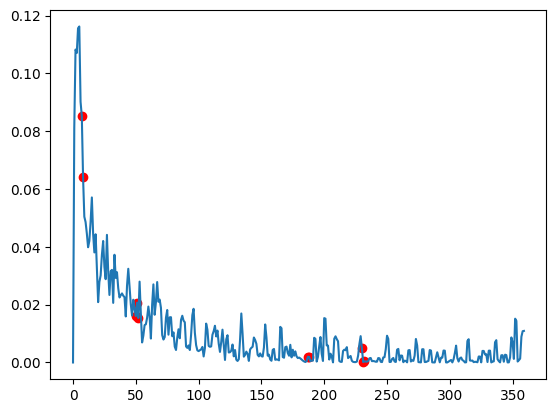

In [80]:
avg_scores = [[] for i in range(label.max()+1)]

for i in range(label.max()+1):
    for j in range(len(label)):
        if label[j] == i:
            if torch.nan in scores[j]:
                print(1)
            avg_scores[i].append(scores[j])
avg_scores = [torch.where(torch.isnan(torch.stack(avg_scores[i])), 0, torch.stack(avg_scores[i])) for i in range(len(avg_scores))]
from matplotlib import pyplot as plt
import numpy as np

key_nodes = np.array([8,9,51,52,53,188,189,231,232,233])-1
# key_nodes = np.array([24,103,104,105,107,123,124,125,128,129,130,173,174,175,176,204,283,284,285,287,303,304,305,308,309,310,353,354,355,356]) - 1


plt.plot(torch.mean(avg_scores[3].cpu().detach(), dim=0))
plt.scatter(key_nodes, torch.mean(avg_scores[3].detach(), dim=0)[key_nodes], c='red')

In [81]:
# calculate Mean Reciprocal Rank
import torch
import numpy as np

def mrr(score, target):
    _,rank = torch.sort(-score, descending=False)
    _,rank = torch.sort(rank, descending=False)
    ranks = []
    for i in range(len(target)):
        ranks.append(rank[target[i]].item()+1)
    
    rank = torch.tensor(ranks)
    return (1 / rank.float()).mean()

def hit10(score, target):
    _, rank = score.sort(dim=-1, descending=True)
    rank = rank[:10]

    hit = 0
    for i in range(len(target)):
        if target[i] in rank:
            hit += 1
    return hit / len(target)

def hit30(score, target):
    _, rank = score.sort(dim=-1, descending=True)
    rank = rank[:30]

    hit = 0
    for i in range(len(target)):
        if target[i] in rank:
            hit += 1
    return hit / len(target)

def wmrr(score, target):
    _, rank = score.sort(dim=-1, descending=True)
    ranks = []
    for i in range(len(target)):
        ranks.append((rank == target[i]).nonzero().item())
    rank = torch.tensor(ranks)
    return (1 / rank.float() * torch.softmax(rank, 0)).mean()

score = torch.tensor(avg_scores[3])
target = torch.tensor([8,9,51,52,53,188,189,231,232,233]) - 1
mrr_mamba = []
for i in range(len(score)):
    # print(hit10(score[i], target))
    # print(mrr(score[i], target))
    mrr_mamba.append(hit10(score[i], target))
    # print(wmrr(score[i], target))
    # print('\n')
# mrr(score, target)
mrr_mamba = torch.tensor(mrr_mamba)
order, index = mrr_mamba.sort()
order[-16:]
# hit10(-score, target)

/tmp/ipykernel_320570/1445882585.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  score = torch.tensor(avg_scores[3])


tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
        0.2000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000])

In [123]:
tmp = np.array([0.0000e+00, 1.6391e-06, 5.0705e-05, 1.8164e-03, 4.6417e-03, 6.3745e-03,
        3.0063e-06, 1.5740e-01, 8.1565e-01, 9.7294e-01, 1.3318e-04, 3.7253e-09,
        3.7253e-09, 1.3534e-05, 2.4738e-03, 1.0676e-04, 6.7887e-04, 1.5343e-03,
        1.3464e-04, 3.8350e-04, 1.0479e-04, 1.3318e-06, 2.7664e-04, 2.7681e-04,
        1.3448e-06, 0.0000e+00, 7.2414e-05, 6.8317e-02, 1.3856e-01, 1.9788e-01,
        8.6242e-03, 4.4479e-04, 1.3039e-08, 4.6667e-03, 4.6665e-03, 2.8126e-07,
        0.0000e+00, 2.3235e-05, 9.4392e-04, 9.9257e-04, 1.4938e-06, 4.4842e-04,
        4.7236e-04, 1.8626e-08, 2.5811e-05, 2.2296e-05, 3.5129e-06, 4.0978e-08,
        1.5495e-04, 2.9911e-03, 1.6359e-02, 2.1656e-01, 2.3608e-01, 9.7193e-06,
        1.8068e-07, 5.0450e-03, 4.6129e-03, 4.3229e-04, 2.4214e-08, 0.0000e+00,
        1.8999e-07, 2.3898e-06, 2.1998e-06, 0.0000e+00, 0.0000e+00, 7.4506e-09,
        7.4506e-09, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 2.8778e-06, 3.0659e-06, 1.8813e-07, 7.8231e-08,
        2.0276e-04, 2.0267e-04, 5.5879e-09, 0.0000e+00, 3.3341e-06, 3.2596e-06,
        7.4506e-08, 0.0000e+00, 2.2165e-07, 5.5473e-02, 8.2395e-02, 2.6910e-02,
        1.2467e-05, 3.7253e-09, 4.0792e-07, 4.0606e-07, 1.8626e-09, 1.5259e-05,
        1.1768e-04, 1.3067e-04, 2.2352e-07, 7.0222e-07, 1.7844e-06, 7.4506e-09,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 2.5146e-07, 4.3958e-07, 6.9104e-07, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0489e-08,
        3.1294e-01, 3.1299e-01, 5.3219e-05, 0.0000e+00, 7.4506e-09, 5.8487e-07,
        5.9232e-07, 7.4506e-09, 5.5799e-05, 5.6311e-05, 5.1968e-07, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 3.4627e-06, 1.4338e-04, 1.4041e-04,
        4.9360e-07, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 9.3132e-09,
        9.3132e-09, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.3039e-08, 1.3039e-08, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.5279e-05,
        1.1303e-03, 1.1426e-03, 3.0454e-06, 7.4506e-09, 5.5879e-09, 0.0000e+00,
        0.0000e+00, 7.4506e-09, 9.3132e-09, 1.8626e-09, 0.0000e+00, 0.0000e+00,
        4.8429e-08, 4.6566e-08, 1.8626e-09, 0.0000e+00, 0.0000e+00, 1.8626e-09,
        1.8626e-09, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0990e-07, 1.3243e-06, 1.2089e-06, 5.5879e-09, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.9372e-05, 6.5091e-03, 6.4900e-03, 1.8813e-07,
        0.0000e+00, 2.4214e-08, 1.8626e-09, 2.2352e-08, 1.8626e-09, 9.9465e-07,
        9.9279e-07, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 3.6135e-07, 3.6135e-07, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.8626e-09, 1.8626e-09, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        4.6082e-06, 5.7556e-06, 1.1493e-06, 0.0000e+00, 1.8626e-09, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 7.4506e-09, 1.3039e-08,
        5.5879e-09, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 8.5682e-08, 8.5682e-08, 0.0000e+00, 0.0000e+00,
        5.5879e-09, 8.5682e-08, 9.1270e-08, 0.0000e+00, 0.0000e+00, 1.0749e-05,
        3.5042e-05, 4.1669e-05, 4.1220e-06, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.8626e-09, 1.8626e-09,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.8626e-09, 5.6271e-06, 5.6289e-06,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.6019e-07,
        1.6019e-07, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.8626e-09, 4.0978e-08, 3.7253e-08, 1.8626e-09,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 7.8417e-07, 1.9714e-05,
        2.0498e-05, 0.0000e+00, 0.0000e+00, 0.0000e+00, 7.4506e-08, 8.5682e-08,
        1.1176e-08, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00])

tmp = torch.nn.Sigmoid()(torch.tensor(tmp)-tmp.mean()) * 100
tmp = torch.nn.Sigmoid()(torch.tensor(tmp)-tmp.mean()) 

/tmp/ipykernel_320570/1579433555.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tmp = torch.nn.Sigmoid()(torch.tensor(tmp)-tmp.mean())


In [124]:
tmp

tensor([0.4384, 0.4384, 0.4387, 0.4496, 0.4672, 0.4780, 0.4384, 0.9754, 1.0000,
        1.0000, 0.4393, 0.4384, 0.4384, 0.4385, 0.4537, 0.4391, 0.4426, 0.4479,
        0.4393, 0.4408, 0.4391, 0.4384, 0.4401, 0.4401, 0.4384, 0.4384, 0.4389,
        0.8115, 0.9613, 0.9909, 0.4920, 0.4412, 0.4384, 0.4673, 0.4673, 0.4384,
        0.4384, 0.4386, 0.4442, 0.4445, 0.4384, 0.4412, 0.4413, 0.4384, 0.4386,
        0.4386, 0.4385, 0.4384, 0.4394, 0.4569, 0.5403, 0.9942, 0.9964, 0.4385,
        0.4384, 0.4697, 0.4670, 0.4411, 0.4384, 0.4384, 0.4384, 0.4384, 0.4384,
        0.4384, 0.4384, 0.4384, 0.4384, 0.4384, 0.4384, 0.4384, 0.4384, 0.4384,
        0.4384, 0.4384, 0.4384, 0.4384, 0.4384, 0.4384, 0.4397, 0.4397, 0.4384,
        0.4384, 0.4385, 0.4385, 0.4384, 0.4384, 0.4384, 0.7575, 0.8595, 0.6047,
        0.4385, 0.4384, 0.4384, 0.4384, 0.4384, 0.4385, 0.4392, 0.4392, 0.4384,
        0.4384, 0.4384, 0.4384, 0.4384, 0.4384, 0.4384, 0.4384, 0.4384, 0.4384,
        0.4384, 0.4384, 0.4384, 0.4384, 

tensor([155, 140, 141, 142, 144, 146, 147, 148, 149, 150, 151, 152, 154, 139,
        157, 158, 159, 160, 164, 165, 168, 171, 172, 173, 175, 115, 100, 101,
        102, 103, 107, 108, 110, 111, 112, 113, 114, 176, 122,   0, 124, 126,
        127, 128, 129, 130, 131, 132, 138, 231, 211, 212, 213, 217, 220, 222,
        223, 224, 225, 226, 227, 230, 209, 232, 233, 234, 235, 236, 237, 239,
        241, 242, 244, 245, 189, 177, 178, 179, 180, 181, 182, 183, 184, 186,
        187, 188, 123, 191, 192, 194, 196, 197, 199, 203, 204, 205, 206, 208,
         64,  78,  24,  23,  22,   9,  75,  73,  72,  12,  40,  70,  69,  68,
         67,  21,  26,  20,  46,  61,  14,  60,  59,  58,  50,  15,  19,  51,
         16,  53,  17,  80,  97,  96,  94,  28,  29,  93,  92,  30,  91,  90,
         89,  88,  87,   2,  34,  81,   5,  84,  83,  33, 170, 200, 228,  18,
        207, 210,  27,  36,  49,  37, 214,  48, 215,  25,  42, 198, 202, 201,
         31, 216, 121, 137, 169, 134,  76,   6,  79, 238, 125,  

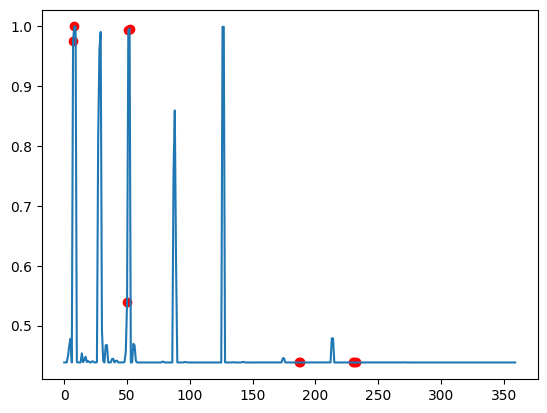

In [125]:
print(index)
avg_scores = [[] for i in range(label.max()+1)]

for i in range(label.max()+1):
    for j in range(len(label)):
        if label[j] == i:
            if torch.nan in scores[j]:
                print(1)
            avg_scores[i].append(scores[j])
avg_scores = [torch.where(torch.isnan(torch.stack(avg_scores[i])), 0, torch.stack(avg_scores[i])) for i in range(len(avg_scores))]
from matplotlib import pyplot as plt
import numpy as np

key_nodes = np.array([8,9,51,52,53,188,189,231,232,233])-1


plt.plot(tmp)
plt.scatter(key_nodes, tmp[key_nodes], c='red')

In [71]:
avg_scores[3][15]

tensor([0.0000e+00, 1.6391e-06, 5.0705e-05, 1.8164e-03, 4.6417e-03, 6.3745e-03,
        3.0063e-06, 1.5740e-01, 8.1565e-01, 9.7294e-01, 1.3318e-04, 3.7253e-09,
        3.7253e-09, 1.3534e-05, 2.4738e-03, 1.0676e-04, 6.7887e-04, 1.5343e-03,
        1.3464e-04, 3.8350e-04, 1.0479e-04, 1.3318e-06, 2.7664e-04, 2.7681e-04,
        1.3448e-06, 0.0000e+00, 7.2414e-05, 6.8317e-02, 1.3856e-01, 1.9788e-01,
        8.6242e-03, 4.4479e-04, 1.3039e-08, 4.6667e-03, 4.6665e-03, 2.8126e-07,
        0.0000e+00, 2.3235e-05, 9.4392e-04, 9.9257e-04, 1.4938e-06, 4.4842e-04,
        4.7236e-04, 1.8626e-08, 2.5811e-05, 2.2296e-05, 3.5129e-06, 4.0978e-08,
        1.5495e-04, 2.9911e-03, 1.6359e-02, 2.1656e-01, 2.3608e-01, 9.7193e-06,
        1.8068e-07, 5.0450e-03, 4.6129e-03, 4.3229e-04, 2.4214e-08, 0.0000e+00,
        1.8999e-07, 2.3898e-06, 2.1998e-06, 0.0000e+00, 0.0000e+00, 7.4506e-09,
        7.4506e-09, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 2.8778e-

# GatedGCN

In [36]:
import torch 

import os
import torch

def files_by_name(dir_path: str, search_string: str) -> list[str]:
    matching_files = []  # List to hold all matching filenames

    # Walk through all directories and files in the given directory
    for root, dirs, files in os.walk(dir_path):
        for file in files:
            if search_string in file and 'explanation_SA' in file:
                matching_files.append(os.path.join(root, file))

    return matching_files


dir_path = './explanations'  
search_string = 'explanation'  

found_files = files_by_name(dir_path, search_string)

attribution_list = []
graph_indices = []
for file_name in found_files:
    file = torch.load(file_name)
    graph_index = int(file_name.split('_')[-1].split('.')[0])
    attribution_list.append(file[0].detach().cpu())
    graph_indices.append(graph_index)

In [39]:
import numpy as np

res_node = []
random_sample = np.random.choice(len(attribution_list), 6)
random_sample = range(len(attribution_list))
for i in random_sample:
    res_node.append(attribution_list[i].node_mask.numpy())
res_node = np.stack(res_node)

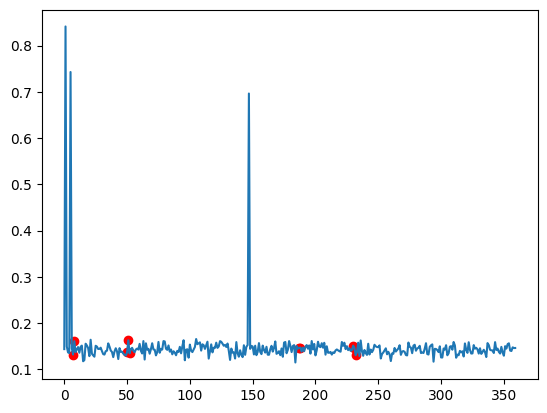

In [38]:
from matplotlib import pyplot as plt

res_node = []
random_sample = np.random.choice(len(attribution_list), 6)
random_sample = range(len(attribution_list))
for i in random_sample:
    res_node.append(attribution_list[i].node_mask.numpy())
res_node = np.stack(res_node)[0]
plt.plot(res_node)
scatter_point = torch.tensor([8,9,51,52,53,188,189,231,232,233]) - 1
for i in scatter_point:
    plt.scatter(i, res_node[i], c='red')

In [42]:
# calculate Mean Reciprocal Rank
import torch
import numpy as np

def mrr(score, target):
    _,rank = torch.sort(-score, descending=False)
    _,rank = torch.sort(rank, descending=False)
    ranks = []
    for i in range(len(target)):
        ranks.append(rank[target[i]].item()+1)
    
    rank = torch.tensor(ranks)
    return (1 / rank.float()).mean()

def hit10(score, target):
    _, rank = score.sort(dim=-1, descending=True)
    rank = rank[:10]

    hit = 0
    for i in range(len(target)):
        if target[i] in rank:
            hit += 1
    return hit / 10

def hit30(score, target):
    _, rank = score.sort(dim=-1, descending=True)
    rank = rank[:30]

    hit = 0
    for i in range(len(target)):
        if target[i] in rank:
            hit += 1
    return hit / 10

def wmrr(score, target):
    _, rank = score.sort(dim=-1, descending=True)
    ranks = []
    for i in range(len(target)):
        ranks.append((rank == target[i]).nonzero().item())
    rank = torch.tensor(ranks)
    return (1 / rank.float() * torch.softmax(rank, 0)).mean()

score = torch.tensor(res_node).squeeze(-1)
target = torch.tensor([8,9,51,52,53,188,189,231,232,233]) -1
mrr_mamba = []
for i in range(len(score)):
    # print(hit10(score[i], target))
    # print(mrr(score[i], target))
    mrr_mamba.append(hit30(score[i], target))
    # print(wmrr(score[i], target))
    # print('\n')
# mrr(score, target)
mrr_mamba = torch.tensor(mrr_mamba)
mrr_mamba.sort()[0][-16:].mean()

tensor(0.2438)